In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

import json

import sys
sys.path.append("../src")
from gait_gft import *


path_to_project = os.path.join('..')
misc_path = os.path.join(path_to_project, 'config')

with open(os.path.join(misc_path,'time_thresholds.json'), 'r') as f:
  time_thresholds = json.load(f)

with open(os.path.join(misc_path,'node_positions.json'), 'r') as f:
    pos_loaded = json.load(f)
    pos = {k: tuple(v) for k, v in pos_loaded.items()}

This repository contains the code developed for the analysis of human gait pathologies under the framework of **Graph Signal Processing (GSP)**.

The methods implemented here focus on modeling the human skeleton as a graph and applying **Graph Fourier Transform (GFT)** to study movement patterns and distinguish between normal and pathological gaits.  

Further details on the methodology and results can be found in my Master’s Thesis: [Graph Fourier Transform: A study of time-dependent graph signals](https://thesis.unipd.it/handle/20.500.12608/91831?mode=simple)

Data source: https://ieee-dataport.org/documents/azure-kinect-3d-skeleton-and-foot-pressure-data-pathological-gaits

In [2]:
from matplotlib.colors import Normalize
from matplotlib import cm

class Visualizer:
    def __init__(self):
        pass  # You can add theme settings, font scaling, etc. here if needed

    def plot_graph_basis(self, graph: GraphModel, figsize=(6.4, 8), cmap='seismic', save_path=None):
        """
        Plot the Laplacian eigenvectors (U matrix) as a heatmap and the eigenvalues as a line plot above.

        Parameters
        ----------
        graph : GraphModel
            GraphModel object with .U, .Lambda, .nodes attributes.
        figsize : tuple
            Size of the figure.
        cmap : str
            Colormap for the heatmap.
        save_path : str or None
            If provided, save the figure to this path.
        """
        U = graph.U
        lambdas = graph.Lambda
        nodes = graph.node_list
        n = graph.n

        fig, (ax1, ax2) = plt.subplots(
            nrows=2, figsize=figsize, sharex=True,
            gridspec_kw={'height_ratios': [1, 3]}
        )

        # --- Upper: Eigenvalues
        width = 0.1
        ax1.scatter(
            np.arange(1, n+1) - 0.5, lambdas,
            color='#9B0014', edgecolor='black', s=50, marker='o', alpha=0.8
        )
        ax1.set_ylabel("Eigenvalue", fontsize=12)
        ax1.set_title(r"$L_N$ Eigenvalues", fontsize=14, pad=10)
        ax1.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
        ax1.tick_params(axis='both', which='major', labelsize=10)
        ax1.set_xlim(-1, len(lambdas) + 1)
        ax1.set_ylim(-width, max(2, lambdas.max()) + width)

        # --- Lower: Heatmap of U
        ax2.set_aspect('auto')
        sns.heatmap(U, cmap=cmap, center=0, cbar=False,
                    xticklabels=False, yticklabels=False, square=True, ax=ax2)

        ax2.set_xlabel("Eigenpair Index", fontsize=12)
        ax2.set_ylabel("Graph Node Index", fontsize=12)
        ax2.set_title(r"$L_N$ Eigenvectors", fontsize=14, pad=10)

        # Gridlines (vertical)
        for x in range(1, n):
            ax2.axvline(x, color='black', linewidth=0.7)

        ax2.set_xticks(np.arange(n) + 0.5)
        ax2.set_xticklabels(range(1, n + 1), fontsize=8, rotation=90)

        ax2.set_yticks(np.arange(n) + 0.5)
        ax2.set_yticklabels(nodes, fontsize=8)

        # --- External colorbar
        heatmap_box = ax2.get_position()
        cbar_height = 0.32
        cbar_bottom = heatmap_box.y0 + (heatmap_box.height - cbar_height) / 2
        cbar_ax = fig.add_axes([0.91, cbar_bottom, 0.02, cbar_height])

        norm = plt.Normalize(vmin=U.min(), vmax=U.max())
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        f = 0.85
        cbar = fig.colorbar(sm, cax=cbar_ax, ticks=[U.min()*f, 0, U.max()*f])
        cbar.ax.set_yticklabels(["-", "0", "+"], fontsize=12)

        # --- Layout
        plt.tight_layout(rect=[0, 0, 0.9, 1], h_pad=1.5)

        if save_path:
            fig.savefig(save_path, dpi=300, bbox_inches='tight')

        plt.show()


    def plot_graph_signal(self, signal,
                          ax,
                          graph: GraphModel,
                          pos: dict,
                          norm_edges=None,
                          font_size=3, edge_width=1,
                          edge_cmap=plt.cm.gray_r,
                          node_size=100,
                          nodes_cmap=plt.cm.seismic,
                          draw_labels=False,
                          grayscale_edges=True,
                          signal_min_max=None,
                          constant_color=None,
                          draw_edges=True,
                          rotation=0,
                          font_color='black',
                          ):
        """
        Plot a graph-signal on its graph representation.

        Parameters
        ----------
        signal : np.ndarray
            1D array of signal values, length = number of nodes.
        ax : matplotlib axis
            Axis on which to draw.
        graph : GraphModel
            Graph structure and node order.
        pos : dict
            Node position layout (dict of node → (x, y)).
        labels : dict
            Node labels for display.
        edges_weights : np.ndarray
            Edge weights (optional).
        norm_edges : Normalize object
            Normalizer for edge colors.
        All other parameters: passed to `nx.draw_networkx_...`
        """
        if pos is None:
            raise ValueError("A position dictionary `pos` must be provided.")

        labels=dict(zip(graph.node_list,graph.node_list))
        edges_weights = np.array([
            graph.graph[u][v].get('weight', 1.0)
            for u, v in graph.graph.edges()
        ])
        if norm_edges is None:
            norm_edges = plt.Normalize(edges_weights.min(), edges_weights.max())


        # Normalize node values
        if signal_min_max is None:
            max_abs_val = np.max(np.abs(signal))
            signal_min_max = (-max_abs_val, max_abs_val)
        else:
            val = max(abs(signal_min_max[0]), abs(signal_min_max[1]))
            signal_min_max = (-val, val)

        norm_signal = plt.Normalize(vmin=signal_min_max[0], vmax=signal_min_max[1])

        # Node colors
        if constant_color is not None:
            node_colors = constant_color
        else:
            node_colors = nodes_cmap(norm_signal(signal))

        # Draw nodes
        nx.draw_networkx_nodes(
            graph.graph, pos,
            node_color=node_colors,
            node_size=node_size,
            # cmap=nodes_cmap,
            ax=ax
        )

        # Draw edges
        if draw_edges:
            if grayscale_edges:
                nx.draw_networkx_edges(
                    graph.graph, pos,
                    edge_color=edges_weights,
                    edge_cmap=edge_cmap,
                    width=edge_width,
                    edge_vmin=min(0, edges_weights.min()),
                    edge_vmax=edges_weights.max(),
                    ax=ax
                )
            else:
                nx.draw_networkx_edges(graph.graph, pos, width=edge_width, ax=ax)

        # Draw labels
        if draw_labels:
            label_texts = nx.draw_networkx_labels(
                graph.graph, pos,
                font_size=font_size,
                font_weight='bold',
                labels=labels,
                ax=ax,
                font_color=font_color
            )
            if rotation != 0:
                for _, t in label_texts.items():
                    t.set_rotation(rotation)

        ax.axis("off")

        pos_X, pos_Y = zip(*pos.values())
        xlims = (min(pos_X)-10, max(pos_X)+10)
        ylims = (min(pos_Y)-10, max(pos_Y)+10)
    
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)


    def plot_normal_modes_grid(self, graph, pos,
                               n_rows=2, n_cols=4,
                               node_size=12,
                               figsize=(6.5, 4),
                               save_path_prefix='First normal modes',
                               **plot_kwargs):
        """
        Plot the first n_freqs = n_rows × n_cols graph Fourier modes in a grid layout.
    
        Parameters
        ----------
        graph : GraphModel
            Graph model with eigenvectors and structure.
        pos : dict
            Node layout positions.
        n_rows : int
            Number of subplot rows.
        n_cols : int
            Number of subplot columns.
        box_flag : bool
            Whether to draw boxes around selected modes.
        highlight_indices : list of int
            Mode indices to draw boxes around (zero-based).
        node_size : int
            Size of graph nodes.
        figsize : tuple
            Size of the full figure.
        save_path_prefix : str
            Prefix for saved filename.
        **plot_kwargs : additional kwargs passed to plot_graph_signal
        """
        U = graph.U
        n_freqs = n_rows * n_cols
        n_freqs = min(n_freqs, graph.n)  # Don't exceed available modes
    
        # Normalize colors across all shown modes
        u_min = U[:, :n_freqs].min()
        u_max = U[:, :n_freqs].max()
        max_val = max([abs(u_min), abs(u_max)])
        norm_u = plt.Normalize(-max_val, max_val)
    
        fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
        axes = axes.flatten()
    
        for i in range(n_freqs):
            ax = axes[i]
            signal = U[:, i]
    
            self.plot_graph_signal(
                signal,
                ax,
                graph,
                pos,
                node_size=node_size,
                signal_min_max=(-max_val, max_val),
                # **plot_kwargs
            )
    
    
            ax.set_title(f'k = {i + 1}', fontsize=10)
    
        # Hide unused axes
        for j in range(n_freqs, len(axes)):
            axes[j].axis("off")
    
        plt.tight_layout()
    
        # Save figure
        save_name = f"../results/{save_path_prefix}.png"
        fig.savefig(save_name, dpi=300)
        plt.show()

    
    def plot_energy_evolution(self, signal:GraphSignal , ax=None, label=None,  title=None, display_timestamps=False):
        """
        Plot the evolution of graph signal energy over time for each axis channel.

        Parameters
        ----------
        gft_dict : dict[str, GraphSignal]
            Dictionary with keys 'x', 'y', 'z' and GraphSignal objects as values.
        frame : int or None
            Optional timestep to highlight with a vertical dashed line.
        ax : matplotlib axis or None
            If None, a new figure and axis will be created.
        """

        if ax is None:
            fig, ax = plt.subplots(1,1,figsize=(9,6))
        
        energy = signal.energy.copy()  # pd.Series indexed by time
        
        if not display_timestamps:
            energy.index = range(len(energy))
            
        sns.lineplot(x=energy.index, y=energy.values, ax=ax, label=label)

        ax.set_xlabel('Timestep', fontsize=15)
        ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

        ax.set_title("Graph-signal time evolution" if title is None else title, fontsize=22)

        
        ax.set_xlabel('Timestep', fontsize=10)
        
        if not display_timestamps:
            n_timesteps = len(energy)
            n_ticks = max(2, int(n_timesteps * 0.2))
            tick_positions = np.linspace(0, n_timesteps - 1, n_ticks, dtype=int)
            
            ax.set_xticks(tick_positions)
            ax.set_xticklabels(tick_positions, fontsize=8)


    def plot_heatmap(self, matrix, ax, v_max=None, include_gradient=True):

        n = matrix.shape[0]
        if v_max is None:
            v_max = np.abs(matrix.values).max()

        sns.heatmap(matrix, ax=ax, cmap='seismic', center=0, cbar=False,
                    vmin=-v_max, vmax=v_max,
                    yticklabels=False)
        
        ax.set_xlabel('Timestep', fontsize=10)
        
        n_timesteps = matrix.shape[1]
        n_ticks = max(2, int(n_timesteps * 0.2))
        tick_positions = np.linspace(0, n_timesteps - 1, n_ticks, dtype=int)
        
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(tick_positions, fontsize=8)
        
        ax.set_yticks(np.arange(n) + 0.5)

        if include_gradient:
            fig = ax.get_figure()
            gradient_ax = fig.add_axes([0.1, -0.05, 0.8, 0.025])  # Position for the colorbar
            gradient = np.linspace(-1, 1, 256).reshape(1, -1)  # Generate gradient data from -1 to 1
            gradient_ax.imshow(gradient, aspect='auto', cmap='seismic', extent=[-1, 1, 0, 1])
            gradient_ax.set_xticks([-1, 0, 1])
            gradient_ax.set_xticklabels(['-', '0', '+'], fontsize=4)
            gradient_ax.set_yticks([])
            gradient_ax.tick_params(axis='x', labelsize=20)

    
    def plot_graph_signal_matrix(self, signal: GraphSignal, ax=None, v_max=None, include_gradient=True, title=None):
        matrix = signal.X
        y_labels = signal.graph.node_list

        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(6, 5))

        self.plot_heatmap(matrix, ax=ax, v_max=v_max, include_gradient=include_gradient)
        ax.set_title("Graph-signal through time" if title is None else title, fontsize=16)
        ax.set_yticklabels(y_labels, fontsize=8)

    
    def plot_gft(self, signal: GraphSignal, ax=None, v_max=None, include_gradient=True, title=None):
        matrix = signal.X_hat
        y_labels = range(1, signal.graph.n+1)

        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(6, 5))

        self.plot_heatmap(matrix, ax=ax, v_max=v_max, include_gradient=include_gradient)
        ax.set_title("GFT through time" if title is None else title, fontsize=16)
        ax.set_yticklabels(y_labels, fontsize=8)



class GaitVisualizer(Visualizer):
    """
    Specialized visualizer for gait analysis tasks.
    Inherits all general-purpose graph visualization methods.
    """

    def __init__(self):
        super().__init__()


    def set_axes_equal(self, ax):
        """
        Make axes of 3D plot have equal scale so that spheres appear as spheres,
        cubes as cubes, etc.
    
        Input
          ax: a matplotlib axis, e.g., as output from plt.gca().
        """
    
        x_limits = ax.get_xlim3d()
        y_limits = ax.get_ylim3d()
        z_limits = ax.get_zlim3d()
    
        x_range = abs(x_limits[1] - x_limits[0])
        x_middle = np.mean(x_limits)
        y_range = abs(y_limits[1] - y_limits[0])
        y_middle = np.mean(y_limits)
        z_range = abs(z_limits[1] - z_limits[0])
        z_middle = np.mean(z_limits)
    
        # The plot bounding box is a sphere in the sense of the infinity
        # norm, hence I call half the max range the plot radius.
        plot_radius = 0.5*max([x_range, y_range, z_range])
    
        ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
        ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
        ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])



# Pending to add: velocity vectors (optional)
    def update_skeleton_frame(self, frame, gait: GaitTrial, ax, show_progress=True,
                              scaling_factor=0.5, display_velocity_vectors=True):
        
        if show_progress:
            print(f"{frame:>3}", end=", " + ("\n" if ((frame+1)%10)==0 else ""))
        ax.cla()  # Clear the previous frame to update the 3D plot

        total_frames = gait.positions.shape[0]
        frame = min([frame,total_frames-1])
        
        data    = gait.positions.iloc[frame].unstack().loc[gait.graph.node_list,:]
        frame_pos = data.apply(tuple,axis=1).to_dict()

        frame_v = min([frame, gait.velocities.shape[0]-1])
        v_frame = gait.velocities.iloc[frame_v].unstack().loc[gait.graph.node_list,:]
        
        
        
        # Nodes scatter plot
        x_coords = data['x'].values
        y_coords = data['y'].values
        z_coords = data['z'].values
        ax.scatter(x_coords, y_coords, z_coords, color='blue')


    
        if display_velocity_vectors:
            # Compute the magnitudes of the vectors
            v_magnitudes = np.linalg.norm(v_frame[['x', 'y', 'z']].values, axis=1)
        
            # Normalize the magnitudes for the colormap
            norm = Normalize(vmin=v_magnitudes.min(), vmax=v_magnitudes.max()*1.2)
            cmap = plt.colormaps['magma']  # Choose a gradient colormap (e.g., 'viridis', 'plasma')
        
            scaled_vectors = v_frame[['x', 'y', 'z']].values * scaling_factor
        
            # Plot the scaled vectors with gradient colors
            for i, (index, row) in enumerate(v_frame.iterrows()):
                start = data.loc[index, ['x', 'y', 'z']].values  # Starting point of the vector
                vector = scaled_vectors[i]  # Scaled vector components
                color = cmap(norm(v_magnitudes[i]))  # Color based on original magnitude
        
                ax.quiver(
                    start[0], start[1], start[2],  # Starting point
                    vector[0], vector[1], vector[2],  # Vector components
                    color=color, length=1.0, normalize=False  # Use scaled length
                )
    

        
        
        edge_xyz = np.array([
                (frame_pos[u], frame_pos[v])
                for u, v in gait.graph.graph.edges()
            ])
        
        # Edges
        for vizedge in edge_xyz:
            ax.plot(*vizedge.T, color="tab:gray")
        
        # Update title and axes labels
        ax.set_title(f"{gait.label.title()}", fontsize=20)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
        ax.set_xlabel("x", fontsize=16)
        ax.set_ylabel("y", fontsize=16)
        ax.set_zlabel("z", fontsize=16)
        
        self.set_axes_equal(ax)

    
    def walking_skeleton_animation(self, gait: GaitTrial,
                                   fps = 24, frames=None,
                                   display_velocity_vectors=True,
                                   show_progress=True,
                                   scaling_factor=0.5):

        print(f"Processing {gait.label.title()} gait trial animation:")
        fig, ax = plt.subplots(1,1, subplot_kw={'projection': '3d'}, figsize=(6, 4))
        ax.view_init(elev=30, azim=45, roll=0)

        if frames is None: frames = gait.positions.shape[0]
        interval = 1000 / fps  # interval in milliseconds
        
        ani = FuncAnimation(fig, self.update_skeleton_frame,
                            frames=frames,
                            interval=interval,
                            repeat=False,
                            fargs=(gait,ax,show_progress,
                                   scaling_factor,
                                   display_velocity_vectors))
    
        ani.save(f"../results/walking_skeleton_{gait.label}_with{'' if display_velocity_vectors else 'out'}_vectors.gif", writer="ffmpeg")



    def plot_energy_evolution_all_components(self, gait: GaitTrial, ax=None, title=None, display_timestamps=False):

        if ax is None:
            fig, ax = plt.subplots(1,1,figsize=(9,6))

        for label, signal in gait.gft_dict.items():
            self.plot_energy_evolution(signal, ax=ax, label=label, title=title, display_timestamps=display_timestamps)

    
    def plot_original_signal_vs_gft(self, gait: GaitTrial):
        
        fig, axes = plt.subplots(3, 2, figsize=(10, 12), sharex=True)
        plt.subplots_adjust(wspace=0.3)
        
        label_size = 16
        
        fig.suptitle(f"Graph-signals and their GFT:\n{gait.label.title()}", fontsize=22, y=0.96)
        
        for row, (channel, signal) in enumerate(gait.gft_dict.items()):
        
            title = f"$V_{channel}$"
            viz.plot_graph_signal_matrix(signal, ax=axes[row,0], include_gradient=False, title=title)
        
            title = f"$\hat{{V}}_{channel}$"
            viz.plot_gft(signal, ax=axes[row,1], include_gradient=False, title=title)
        
            axes[row, 0].set_ylabel('Node', fontsize=label_size)
            axes[row, 1].set_ylabel('Normal mode', fontsize=label_size)
        
            if row == 2:
                axes[row, 0].set_xlabel('Timestep', fontsize=10)
                axes[row, 1].set_xlabel('Timestep', fontsize=10)
            else:
                axes[row, 0].set_xlabel('')
                axes[row, 1].set_xlabel('')
        
        
        
        # Define vertical span (0 = bottom of figure, 1 = top)
        v_min = 0.1  # adjust to leave some margin
        v_max = 0.9
        
        left_ax = axes[0, 0].get_position()
        right_ax = axes[0, 1].get_position()
        
        # Midpoint between right edge of left_ax and left edge of right_ax
        x_sep = (left_ax.x1 + right_ax.x0) * 0.48
        
        # Add vertical middle line
        fig.lines.append(plt.Line2D([x_sep, x_sep], [v_min, v_max], transform=fig.transFigure,
                                    color='black', linewidth=0.85))
        
        
        gradient_ax = fig.add_axes([0.1, 0.01, 0.8, 0.025])
        gradient = np.linspace(-1, 1, 256).reshape(1, -1)
        gradient_ax.imshow(gradient, aspect='auto', cmap='seismic', extent=[-1, 1, 0, 1])
        gradient_ax.set_xticks([-1, 0, 1])
        gradient_ax.set_xticklabels(['-', '0', '+'], fontsize=4)
        gradient_ax.set_yticks([])
        gradient_ax.tick_params(axis='x', labelsize=20)
        # fig.savefig(f'../results/original_signal_vs_gft.png', dpi=300, bbox_inches='tight')
        plt.show()


    def plot_compare_gait_types(self, gaits_dict: dict[str, GaitTrial], save_name: str = None):
        
        fig, axes = plt.subplots(4, len(gaits_dict), figsize=(35, 25))
        plt.subplots_adjust(wspace=0.3)
        
        label_size = 16        
        
        for col, (pathology, gait) in enumerate(gaits_dict.items()):
            
            pathology += ' gait' if pathology == 'normal' else ''
            title = f"{pathology.title()} energy"
            self.plot_energy_evolution_all_components(gait, ax=axes[0,col], title=title)
            for row, (channel, signal) in enumerate(gait.gft_dict.items(), start=1):
        
                title = f"$\hat{{V}}_{{{channel}}}$ - {pathology.title()}"
                self.plot_gft(signal, ax=axes[row,col], include_gradient=False, title=title)
        
                if col == 0:
                    axes[row, col].set_ylabel('Normal mode', fontsize=label_size)
                    axes[0,col].set_ylabel('Graph-signal Energy', fontsize=label_size)
        
                if row == 3:
                    axes[row, col].set_xlabel('Timestep', fontsize=10)
                    axes[row, col].set_xticklabels(axes[row, col].get_xticklabels(), rotation=90)
                else:
                    axes[row, col].set_xticklabels([], fontsize=label_size)
        
        # Define vertical span (0 = bottom of figure, 1 = top)
        v_min = 0.1  # adjust to leave some margin
        v_max = 0.9
        
        # Loop through the gaps between column 0–1 and column 1–2
        for col in range(len(gaits_dict)-1):
            left_ax = axes[0, col].get_position()
            right_ax = axes[0, col + 1].get_position()
        
            # Midpoint between right edge of left_ax and left edge of right_ax
            x_sep = (left_ax.x1 + right_ax.x0) / 2
        
            # Add vertical line
            fig.lines.append(plt.Line2D([x_sep, x_sep], [v_min, v_max], transform=fig.transFigure,
                                        color='black', linewidth=0.85))
        
        gradient_ax = fig.add_axes([0.1, 0.03, 0.8, 0.025])
        gradient = np.linspace(-1, 1, 256).reshape(1, -1)
        gradient_ax.imshow(gradient, aspect='auto', cmap='seismic', extent=[-1, 1, 0, 1])
        gradient_ax.set_xticks([-1, 0, 1])
        gradient_ax.set_xticklabels(['-', '0', '+'], fontsize=4)
        gradient_ax.set_yticks([])
        gradient_ax.tick_params(axis='x', labelsize=20)

        if save_name is not None:
            fig.savefig(f'../results/{save_name}.png', dpi=300, bbox_inches='tight')
        plt.show()

<>:533: SyntaxWarning: invalid escape sequence '\h'
<>:588: SyntaxWarning: invalid escape sequence '\h'
<>:533: SyntaxWarning: invalid escape sequence '\h'
<>:588: SyntaxWarning: invalid escape sequence '\h'
C:\Users\rdm42\AppData\Local\Temp\ipykernel_5984\3800294024.py:533: SyntaxWarning: invalid escape sequence '\h'
  title = f"$\hat{{V}}_{channel}$"
C:\Users\rdm42\AppData\Local\Temp\ipykernel_5984\3800294024.py:588: SyntaxWarning: invalid escape sequence '\h'
  title = f"$\hat{{V}}_{{{channel}}}$ - {pathology.title()}"


# Graph Definition

Read edge list and define the graph model:

In [3]:
with open(os.path.join(misc_path, 'links.txt'),'r') as f:
    text = f.read()

nodes = [line.split('\t')[1] for line in text.split('\n')]
edges = [tuple(line.split('\t')[1:]) for line in text.split('\n')[1:]]

skeleton = GraphModel(edges, node_list=nodes)

Visualize the network's spectral structure:

C:\Users\rdm42\AppData\Local\Temp\ipykernel_5984\3800294024.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1], h_pad=1.5)


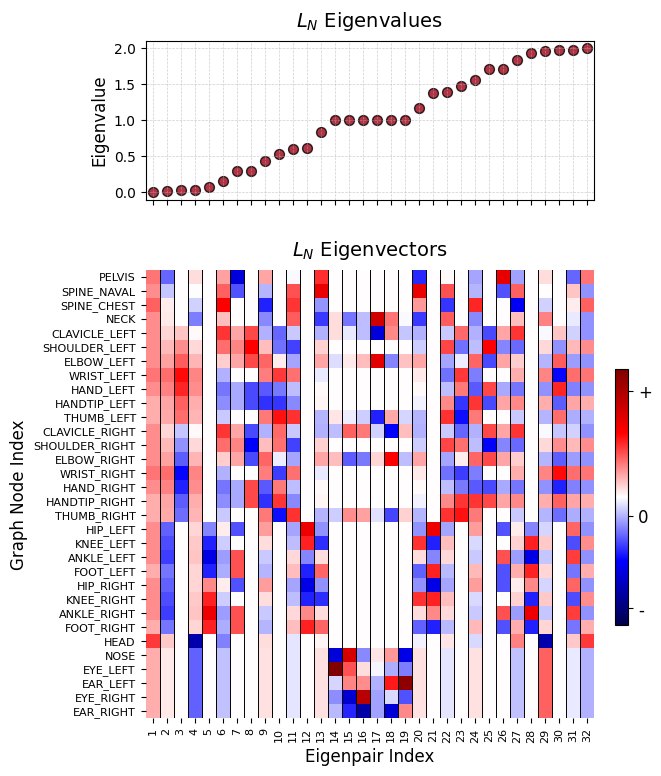

In [4]:
viz = Visualizer()
viz.plot_graph_basis(skeleton)

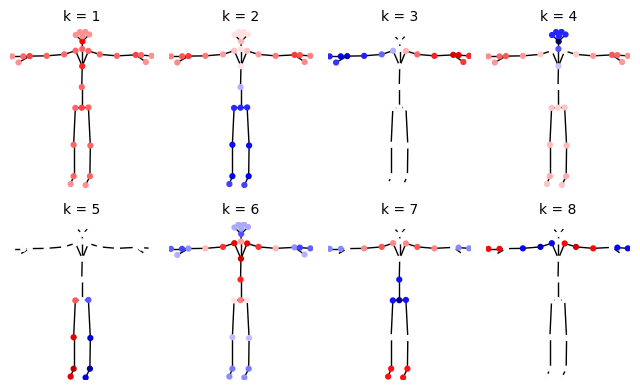

In [5]:
viz = Visualizer()
viz.plot_normal_modes_grid(skeleton, pos)

# Data Preprocessing

Read and preprocess signal data

In [6]:
path_to_zip = os.path.join(path_to_project, 'data', 'HDA_proj_A2.zip')
preproc = SkeletonPreprocessor(path_to_zip, nodes, time_thresholds)

r = preproc.load_and_process('subject1/normal/trial3/skeleton.csv')

r.head()

PELVIS                     SPINE_NAVAL            \
                                x         y         z           x         y   
2020-09-01 11:39:42.575  0.034774 -0.424728  0.867881    0.050272 -0.408131   
2020-09-01 11:39:42.605  0.039393 -0.419787  0.867807    0.055276 -0.403326   
2020-09-01 11:39:42.635  0.045329 -0.409982  0.868456    0.061105 -0.393985   
2020-09-01 11:39:42.665  0.046576 -0.406704  0.869113    0.062253 -0.390760   
2020-09-01 11:39:42.695  0.047960 -0.399230  0.869436    0.063882 -0.382442   

                                  SPINE_CHEST                          NECK  \
                                z           x         y         z         x   
2020-09-01 11:39:42.575  1.042860    0.061215 -0.406153  1.183480  0.080219   
2020-09-01 11:39:42.605  1.042762    0.066418 -0.401370  1.183369  0.085658   
2020-09-01 11:39:42.635  1.043570    0.072129 -0.393022  1.184279  0.090822   
2020-09-01 11:39:42.665  1.044304    0.073288 -0.389521  1.185061  0.091767   
2020-09-01 11:39:42.695  1.044568    0.075177 -0.379866  1.185318  0.093747   

                         ...  EYE_LEFT  EAR_LEFT                      \
                         ...         z         x         y         z   
2020-09-01 11:39:42.575  ...  1.529657  0.008800 -0.347416  1.536911   
2020-09-01 11:39:42.605  ...  1.524916  0.011357 -0.341244  1.532503   
2020-09-01 11:39:42.635  ...  1.528464  0.015427 -0.335462  1.533330   
2020-09-01 11:39:42.665  ...  1.530916  0.017273 -0.330647  1.535640   
2020-09-01 11:39:42.695  ...  1.530588  0.020184 -0.318984  1.537003   

                        EYE_RIGHT                     EAR_RIGHT            \
                                x         y         z         x         y   
2020-09-01 11:39:42.575  0.112419 -0.228415  1.524115  0.172681 -0.342600   
2020-09-01 11:39:42.605  0.114789 -0.221856  1.521669  0.175264 -0.335450   
2020-09-01 11:39:42.635  0.119245 -0.216045  1.525884  0.179419 -0.330100   
2020-09-01 11:39:42.665  0.121957 -0.211953  1.527518  0.181430 -0.326650   
2020-09-01 11:39:42.695  0.124370 -0.200021  1.526280  0.184412 -0.314472   

                                   
                                z  
2020-09-01 11:39:42.575  1.533377  
2020-09-01 11:39:42.605  1.536637  
2020-09-01 11:39:42.635  1.539373  
2020-09-01 11:39:42.665  1.538960  
2020-09-01 11:39:42.695  1.537503  

[5 rows x 96 columns]

# Signal and Gait definition

Define a `GaitTrial` object, holding the `GraphModel` and graph-signal data in every spatial axis of movement:

In [7]:
gait = GaitTrial(r, skeleton, label='normal')

Visualization of velocity signal in $y$-axis at a given timestep:

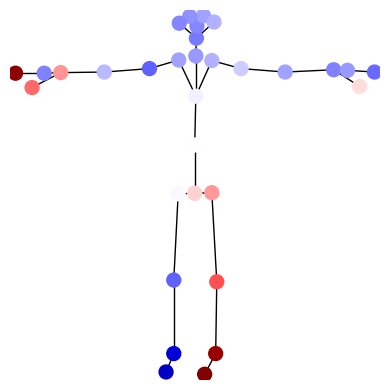

In [8]:
# Example setup
viz = Visualizer()

signal = gait.get_velocity_matrix('y')[:, 10]  # shape: (n_nodes,)

# Plot the signal
fig, ax = plt.subplots(figsize=(4, 4))

viz.plot_graph_signal(
    signal=signal,
    ax=ax,
    graph=skeleton,
    pos=pos
)

plt.tight_layout()
plt.show()

Plot the graph-energy through time for the $y$-axis velocity component:

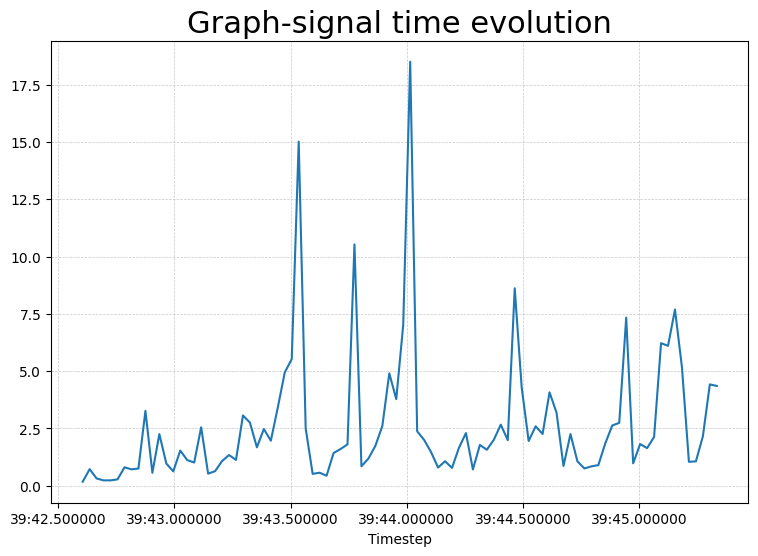

In [9]:
viz = Visualizer()
viz.plot_energy_evolution(gait.vy, display_timestamps=True)

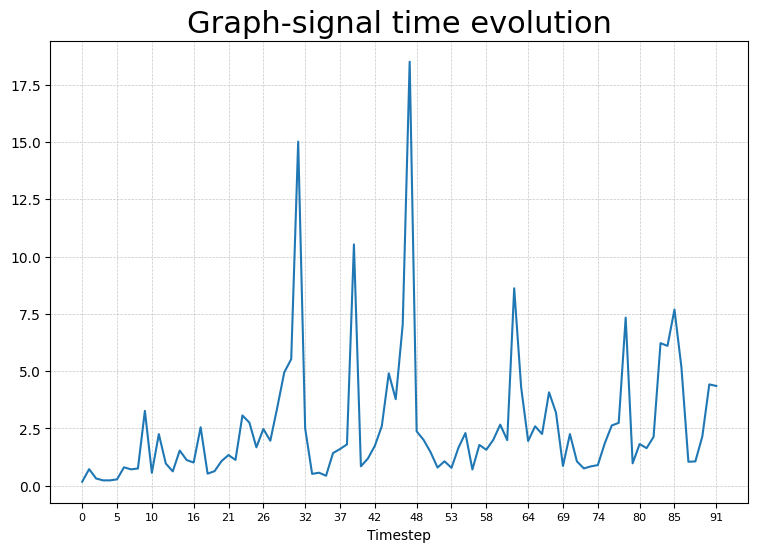

In [10]:
viz = Visualizer()
viz.plot_energy_evolution(gait.vy, display_timestamps=False)

Plot the graph-energy through time for all the velocity components:

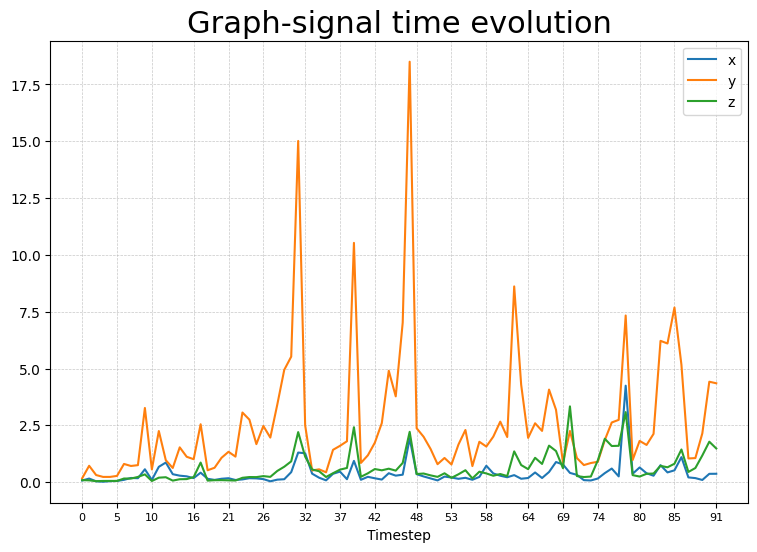

In [11]:
gaitviz = GaitVisualizer()
gaitviz.plot_energy_evolution_all_components(gait)

Gait animation (saved in `results` directory):

Processing Normal gait trial animation:
  0,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9, 
 10,  11,  12,  13,  14,  15,  16,  17,  18,  19, 
 20,  21,  22,  23,  24,  25,  26,  27,  28,  29, 
 30,  31,  32,  33,  34,  35,  36,  37,  38,  39, 
 40,  41,  42,  43,  44,  45,  46,  47,  48,  49, 
 50,  51,  52,  53,  54,  55,  56,  57,  58,  59, 
 60,  61,  62,  63,  64,  65,  66,  67,  68,  69, 
 70,  71,  72,  73,  74,  75,  76,  77,  78,  79, 
 80,  81,  82,  83,  84,  85,  86,  87,  88,  89, 
 90,  91,  92, 

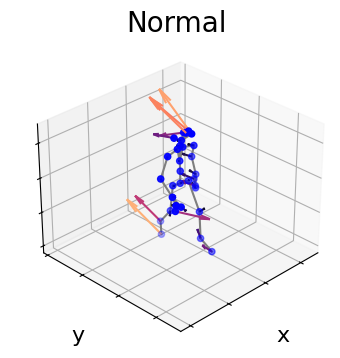

In [12]:
gaitviz = GaitVisualizer()
gaitviz.walking_skeleton_animation(gait)

Processing Normal gait trial animation:
  0,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9, 
 10,  11,  12,  13,  14,  15,  16,  17,  18,  19, 
 20,  21,  22,  23,  24,  25,  26,  27,  28,  29, 
 30,  31,  32,  33,  34,  35,  36,  37,  38,  39, 
 40,  41,  42,  43,  44,  45,  46,  47,  48,  49, 
 50,  51,  52,  53,  54,  55,  56,  57,  58,  59, 
 60,  61,  62,  63,  64,  65,  66,  67,  68,  69, 
 70,  71,  72,  73,  74,  75,  76,  77,  78,  79, 
 80,  81,  82,  83,  84,  85,  86,  87,  88,  89, 
 90,  91,  92, 

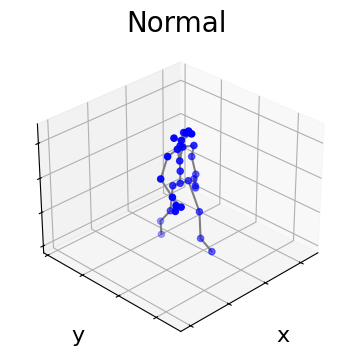

In [13]:
gaitviz.walking_skeleton_animation(gait, display_velocity_vectors=False)

# Comparing gait types

Animation grid for one instance of every gait type (saved in `results` directory):

In [14]:
fnames = [
    'subject12/normal/trial1/skeleton.csv',
    'subject10/trendelenburg/trial1/skeleton.csv',
    'subject10/steppage/trial1/skeleton.csv',
    'subject10/antalgic/trial10/skeleton.csv',
    'subject1/stiff-legged/trial11/skeleton.csv',
    'subject1/lurching/trial1/skeleton.csv'
]

gaits_dict = dict()
min_frames = np.inf

for fname in fnames:
    gait_label = fname.split('/')[1]
    r = preproc.load_and_process(fname)
    gait = GaitTrial(r, skeleton, label=gait_label)

    gaits_dict[gait_label] = gait
    min_frames = min([min_frames, r.shape[0]])

  0,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9, 
  0, 

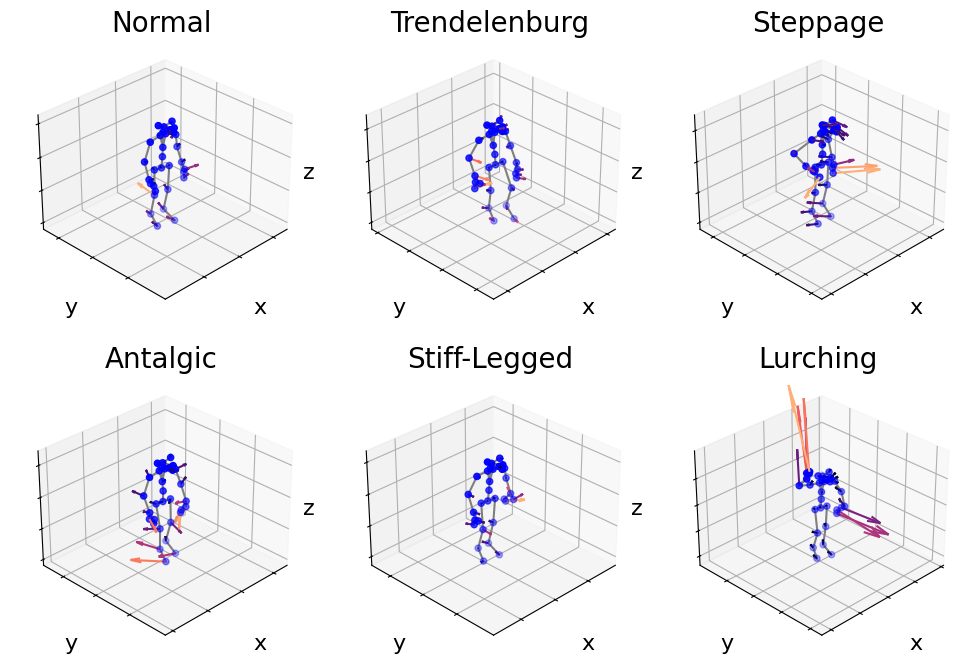

In [15]:
fig, axes = plt.subplots(2, 3, subplot_kw={'projection': '3d'}, figsize=(12, 8))
axes = axes.flatten()
[ax.view_init(elev=30, azim=45, roll=0) for ax in axes]

gaitviz = GaitVisualizer()

def update_grid(frame, gaits_dict):

    print(f"{frame:>3}", end=", " + ("\n" if ((frame+1)%10)==0 else ""))

    for ax, (label, gait) in zip(axes, gaits_dict.items()):
        gaitviz.update_skeleton_frame(frame, gait, ax, show_progress=False)

fps = 12  # frames per second
interval = 1000 / fps  # interval in milliseconds

ani = FuncAnimation(fig, update_grid, frames=10,#min_frames,
                    interval=interval, repeat=False, fargs=(gaits_dict,))

ani.save(f"../results/3d_grid_animation.gif", writer="ffmpeg")

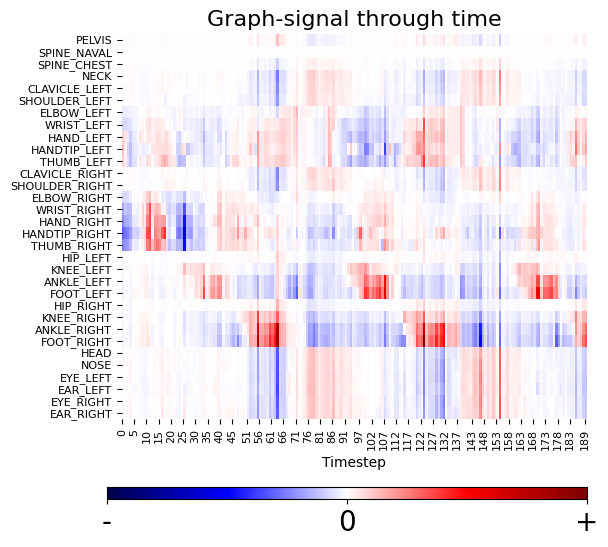

In [16]:
viz.plot_graph_signal_matrix(gait.vy)

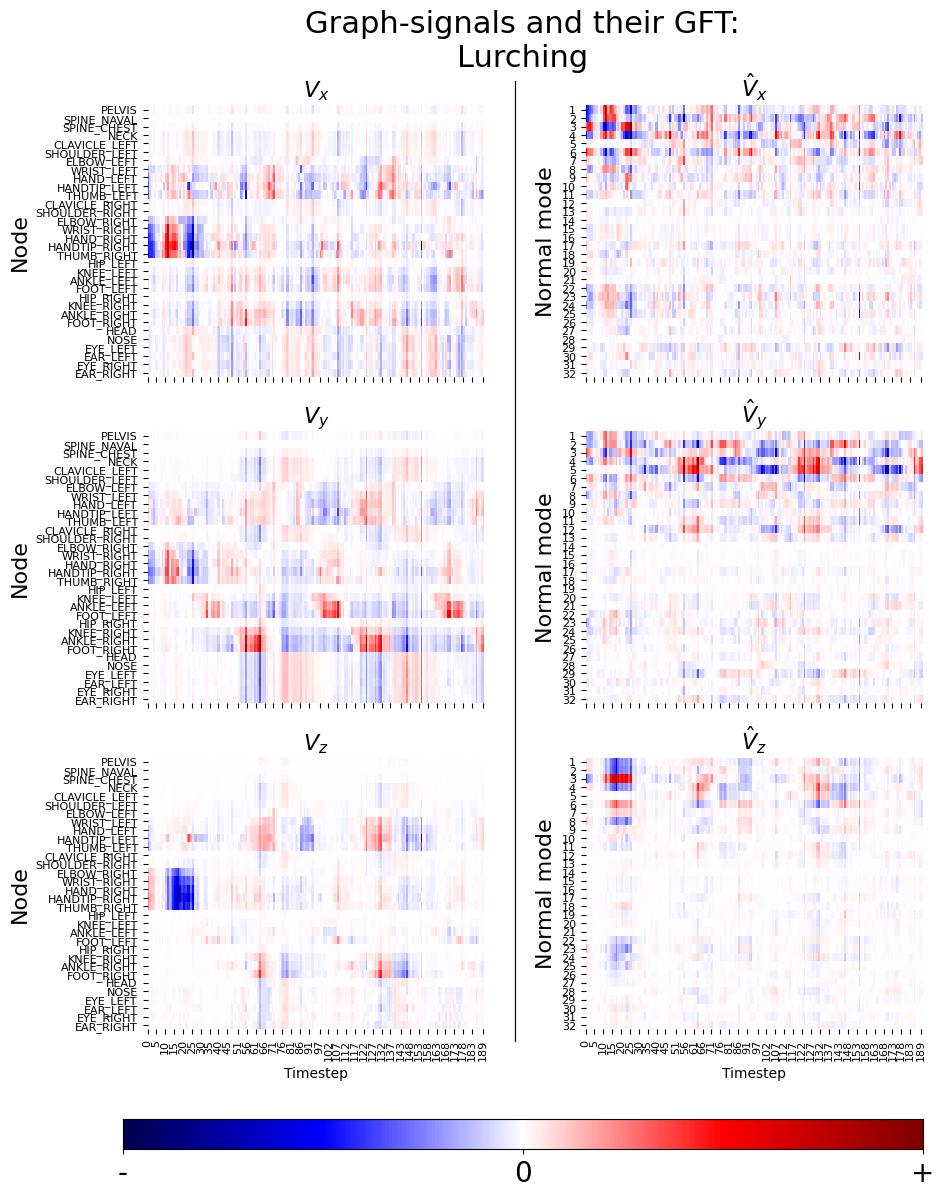

In [17]:
gaitviz.plot_original_signal_vs_gft(gait)

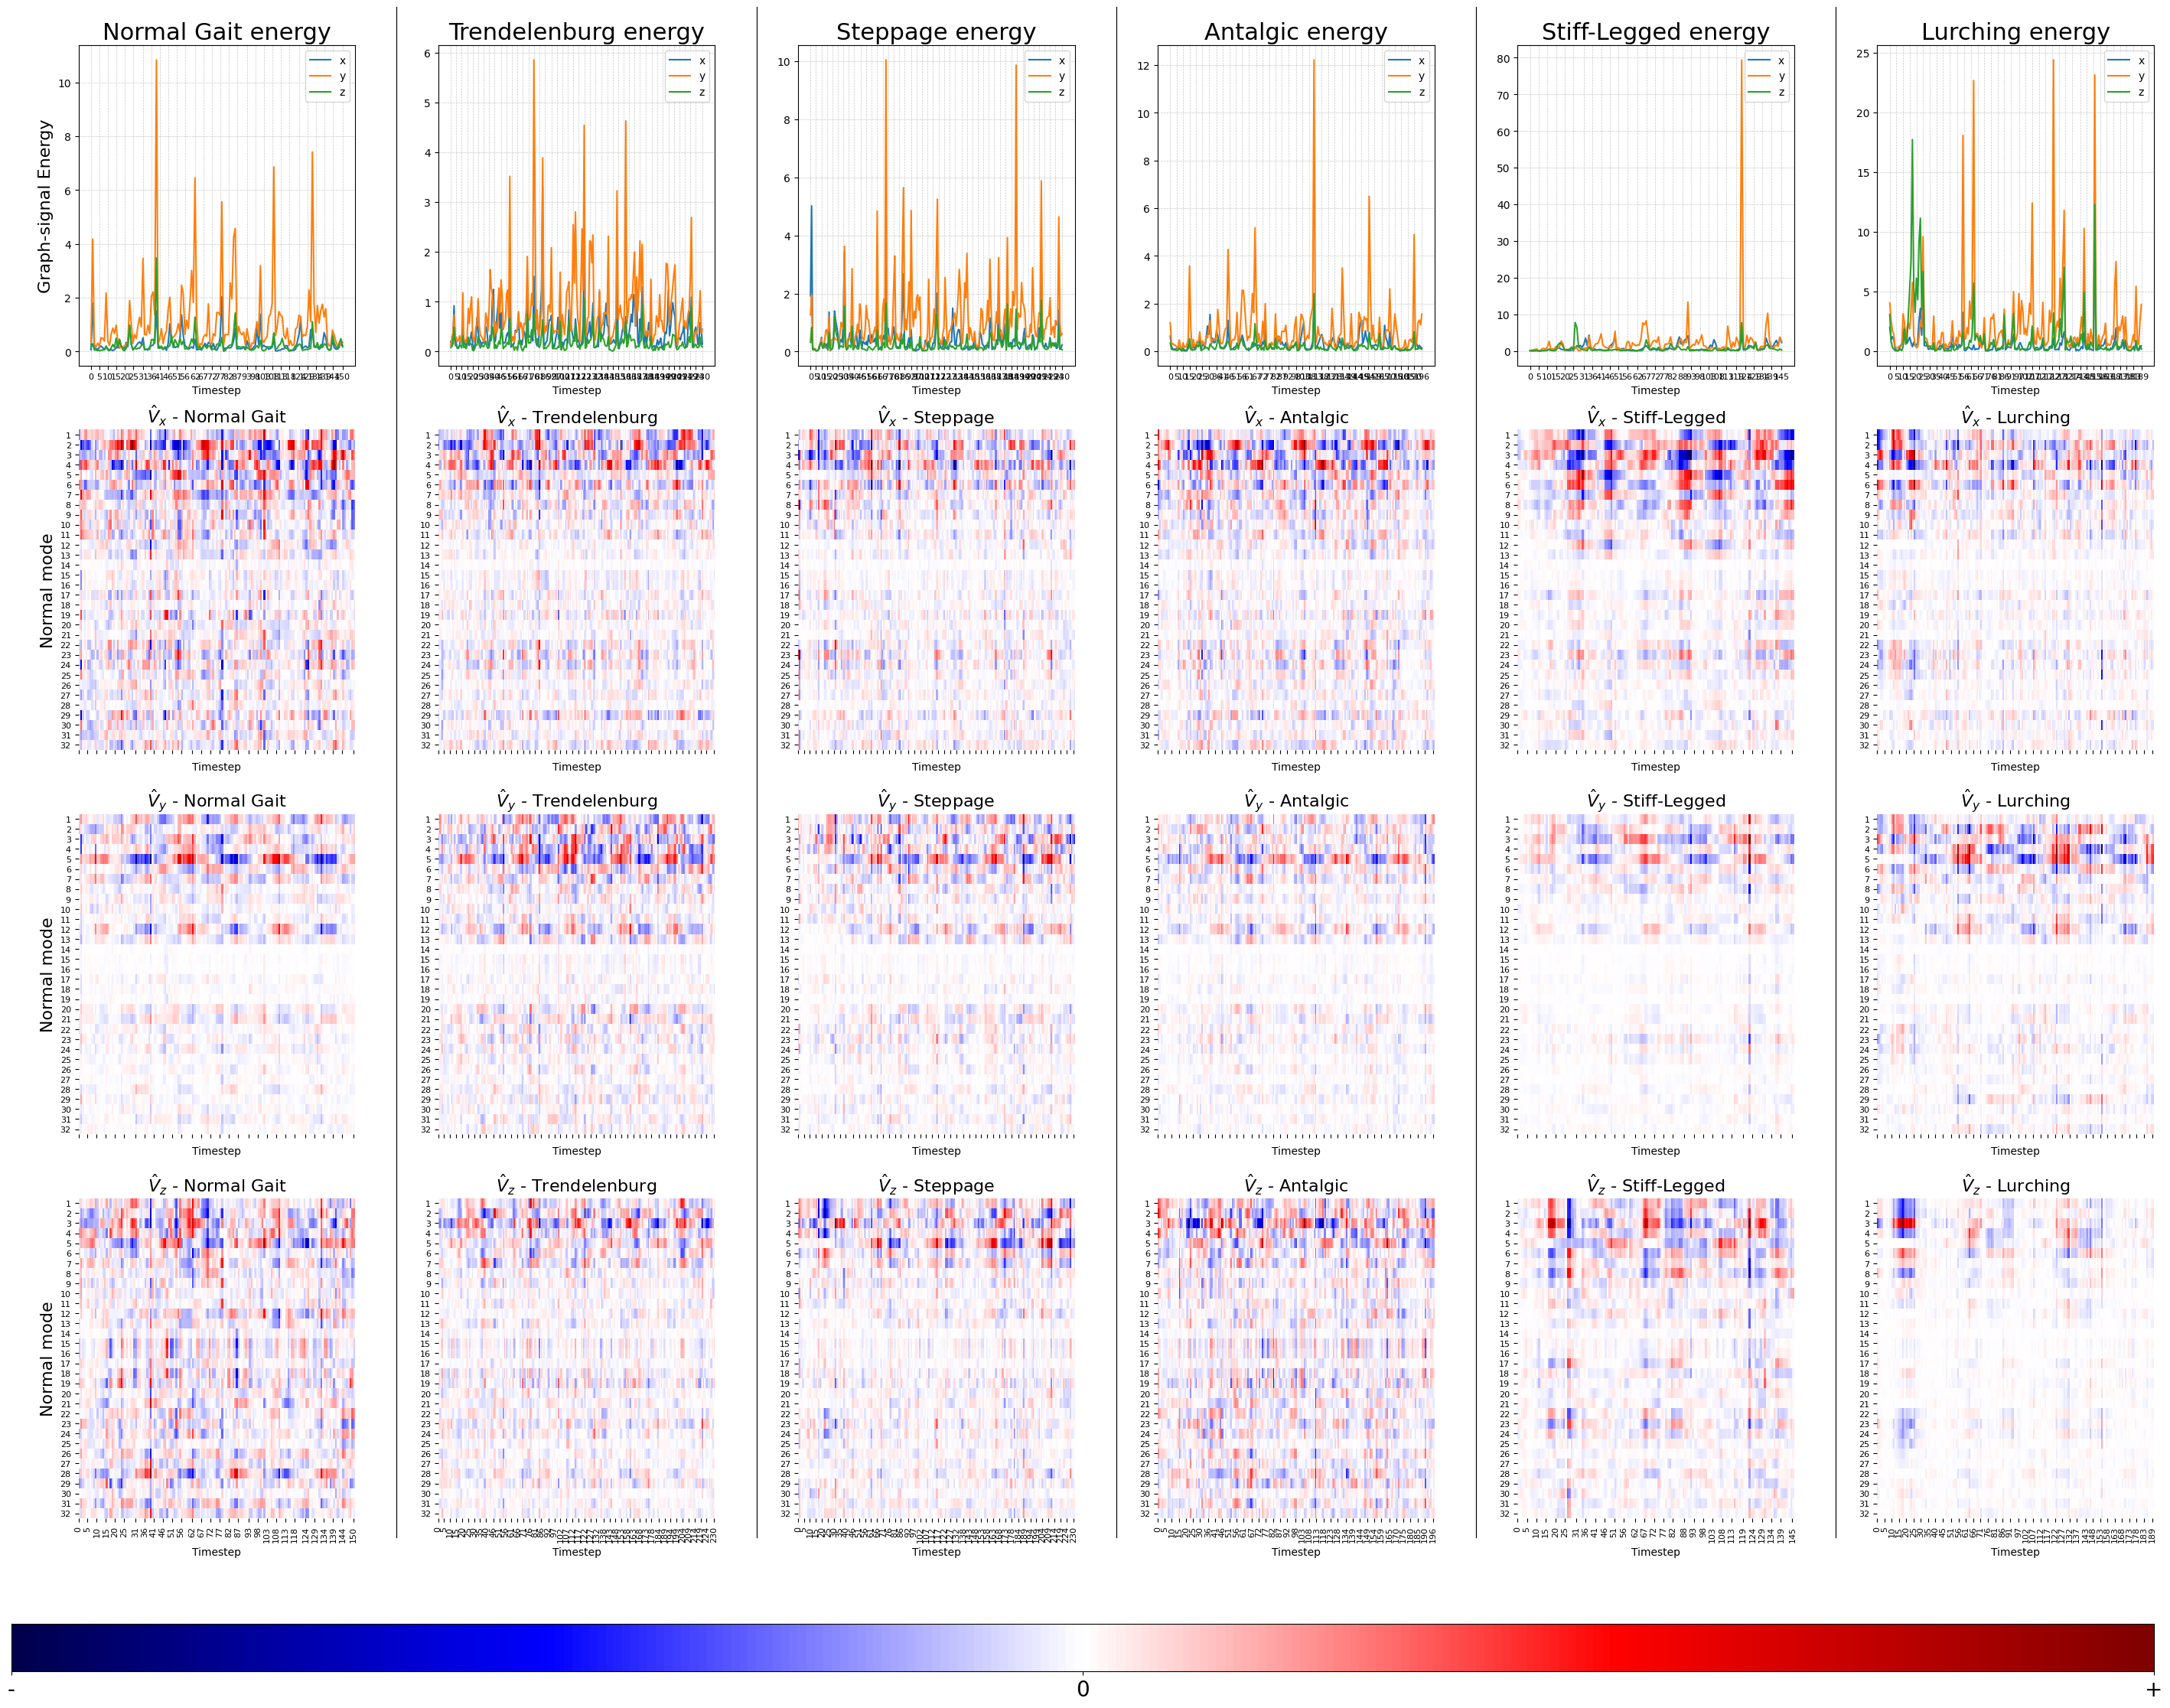

In [18]:
gaitviz.plot_compare_gait_types(gaits_dict)

In [19]:
# El objeto gait debe:
# -tener metodo de filtro, que guarde en filtered signal
# -usando el filtered signal, que sea capaz de recuperar las posiciones originales

In [21]:
# - Notebook coherente, mostrando resultados (que el lector interprete el código)

# - Animaciones más relevantes (
    # [GFT(t) + energia, con esqueleto a un lado, barra vertical que recorra los modos normales])

In [22]:
# Pendiente: README.md del github